# Parallel Genetic Algorithm Using PySpark for Knapsack Problem    
    Author: Furkan Cantürk
    Date: 15.01.2021

In [1]:
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf
from pyspark.sql import functions as F
import os
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
import csv
import pyspark
import matplotlib.pyplot as plt
import pickle
import random
import pandas as pd
from time import time, sleep
import numpy as np
from copy import deepcopy
np.random.seed(1)
random.seed(1)

## Knapsack Instance Generation

Number of items: 1000
Total knapsack capacity: 303414
10 505.69 1000
0 253.558 930


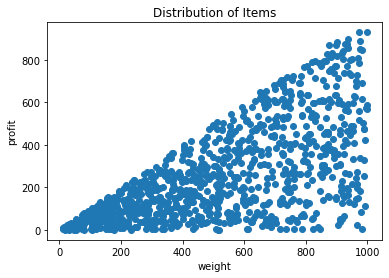

In [2]:
n_items = 1000
min_w = 10
max_w = min_w * 100
weight = np.random.randint(min_w, max_w+1, n_items).astype(int)
profit = ((np.random.random(n_items)) * weight).astype(int) 
item_idx = np.arange(n_items)

min_p = np.min(profit)
max_p = np.max(profit)
mean_p = np.mean(profit)
mean_w = np.mean(weight)

W = int(mean_w * n_items * 0.6)
print("Number of items:",n_items)
print("Total knapsack capacity:", W)
print(min_w, mean_w, max_w)
print(min_p, mean_p, max_p)
plt.scatter(x=weight, y=profit)
plt.xlabel("weight")
plt.ylabel("profit")
plt.title("Distribution of Items")
plt.show()

## Initial Population Generation

In [3]:
population_size = 10000
n_generations = 1
init_population = np.random.randint(0, 2, (int(population_size*1.5),n_items), dtype=bool)
init_population = list(filter(lambda chromosome: np.sum(chromosome * weight) <= W, init_population))[:population_size]
init_profits = np.sum(np.array(init_population) * profit, axis=1)
init_mean_profit = np.mean(init_profits)
init_max_profit = np.max(init_profits)
print("Population size:", len(init_population))
print("Mean profit:", init_mean_profit)
print("Max. profit:", init_max_profit)

Population size: 10000
Mean profit: 126847.301
Max. profit: 145100


# Greedy Heuristic Solution

In [4]:
ratio = profit/weight
sorted_item_idx = sorted(item_idx, key=lambda x: ratio[x], reverse=True)
total_w = 0
total_p = 0
knapsack = []
for i in sorted_item_idx:
    if total_w + weight[i] <= W:
        knapsack.append(i)
        total_w += weight[i]
        total_p += profit[i]
print("#selected items:",len(knapsack), "total weight:",total_w, "total profit:",total_p)

#selected items: 598 total weight: 303406 total profit: 212316


In [26]:
spark.stop()

## Spark Session

In [27]:
n_processors = 2
spark = SparkSession.builder \
       .master(f"local[{n_processors}]") \
       .appName("test") \
       .config("spark.driver.memory", "5g")\
       .getOrCreate()
sc = spark.sparkContext
sql_context = SQLContext(sc)
sql_context.setConf("spark.sql.execution.arrow.pyspark.enabled", "true")
print("#parallel processors:", sc.defaultParallelism)
sc

#parallel processors: 2


<SparkContext master=local[2] appName=test>

In [21]:
spark.stop()

In [6]:
spark.sparkContext._conf.getAll() 

[('spark.app.name', 'test'),
 ('spark.driver.host', 'DESKTOP-192JFUF'),
 ('spark.driver.port', '51296'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.memory', '5g'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.master', 'local[1]'),
 ('spark.app.id', 'local-1610877049907')]

# Parallel GA

In [11]:
def produce_new_generation(i, sub_population):
    global gn, migration_period
    population_lst = list(sub_population) 
    pop_size = len(population_lst)
    
    if gn > migration_period and gn % migration_period == 0:
        print(i, gn)
        try:
            best_individuals = [pickle.load(open(f"best{part_id}.pkl", "rb")) for part_id in range(n_partitions) if part_id != i]
            population_lst.extend(best_individuals)
        except:
            print("Other executor is writing on the file right now")
            print("Waiting for 0.001 seconds")
            sleep(0.001)
            best_individuals = [pickle.load(open(f"best{part_id}.pkl", "rb")) for part_id in range(n_partitions) if part_id != i]
            population_lst.extend(best_individuals)

        
    mating_pool = []
    for _i in range(pop_size):
        parent_1, parent_2 = random.choices(population_lst, k=2)
        selected_p = random.choices([parent_1, parent_2], k=1, weights=[parent_1['profit'], parent_2['profit']])[0]
        mating_pool.append(selected_p)
    
    new_generation = []

    iter_pool = iter(mating_pool)
    p1 = next(iter_pool)
    best_individual = p1
    new_gen_profits = []
   
    while p1:
        p2 = next(iter_pool, False)
        if not p2:
            break
        c1, c2 = generate_children(i, p1, p2, n_trials=10)
        i1, i2 = choose(p1, p2, c1, c2)

        if i1.profit > best_individual.profit:
            best_individual = i1
        elif i2.profit > best_individual.profit:   
            best_individual = i2
        
        if (W - i1.weight)/W > random.random():
            i1 = mutation(i1)
        elif (W - i2.weight)/W > random.random():
            i2 = mutation(i2)
            
        new_generation.extend([i1, i2])
        new_gen_profits.extend([i1.profit, i2.profit])
        
        p1 = next(iter_pool, False)
    
    with open(f"best{i}.pkl", "wb") as f:
        pickle.dump(best_individual, f)
        f.close()
    if save_population:
        with open(f"sub_population_{i}.csv", "a") as f:
            wr = csv.writer(f, dialect='excel')
            wr.writerow(new_gen_profits)

    return new_generation

def generate_children(i, parent_1, parent_2, n_trials):
    for i in range(n_trials):
        child_1, child_2 = crossover(i, parent_1, parent_2)
        if child_1.weight <= W and child_2.weight <= W:
            return child_1, child_2
    return parent_1, parent_2

def choose(parent_1, parent_2, child_1, child_2):
    return sorted([parent_1, parent_2, child_1, child_2], key=lambda i: -i.profit)[:2]

def crossover(i, parent_1, parent_2, n_splits=1):
    split = next(splits[i%4]())
    new_chrom_1 = np.hstack((parent_1.chromosome[:split], parent_2.chromosome[split:]))
    new_chrom_2 = np.hstack((parent_2.chromosome[:split], parent_1.chromosome[split:]))    
    child_1 = Row(chromosome=new_chrom_1, profit=int(np.sum(new_chrom_1 * profit)), weight=int(np.sum(new_chrom_1 * weight)))
    child_2 = Row(chromosome=new_chrom_2, profit=int(np.sum(new_chrom_2 * profit)), weight=int(np.sum(new_chrom_2 * weight)))
    return child_1, child_2

def s0():
    yield np.random.randint(0, n_items*0.25)
def s1():
    yield np.random.randint(n_items*0.25, n_items*0.5)
def s2():
    yield np.random.randint(n_items*0.5, n_items*0.75)
def s3():
    yield np.random.randint(n_items*0.75, n_items)
    
splits = {0: s0, 1:s1, 2:s2, 3:s3}

def mutation(individual, n_trials=5):
    n_genes_to_be_mutated = int((W - individual.weight) / mean_w)
    for x in range(n_trials):
        new_chro = individual.chromosome.copy()
        selected_genes = random.choices((new_chro == False).nonzero()[0], k=n_genes_to_be_mutated)
        new_chro[selected_genes] = True
        new_w = int(np.sum(new_chro * weight))
        if new_w <= W:
            new_p = int(np.sum(new_chro * profit))
            return Row(chromosome=new_chro, profit=new_p, weight=new_w)
        else:
            del new_chro
    return individual

def increment_generation_time(x):
    global generation_no
    generation_no.add(1/n_partitions)


results = []
periods = [2, 4, 8, 16, 32]
n_generations = 64
n_partitions = 4
save_population = False
for p in periods:      
    st = time()

    rdd_of_rows = sc.parallelize([Row(chromosome=chromosome, 
                                      profit=int(np.sum(chromosome * profit)), 
                                      weight=int(np.sum(chromosome * weight))) 
                                  for chromosome in init_population],
                                 n_partitions)

    migration_period = p
    generation_no = sc.accumulator(1.0)
    migrant_freq = 1/migration_period 

    for gen in range(1, n_generations+1):
        gn = generation_no.value
        rdd_of_rows = rdd_of_rows.mapPartitionsWithIndex(produce_new_generation)
        if gen > n_generations:
            if gen%migration_period == 0:
                rdd_of_rows.foreachPartition(increment_generation_time)
            else:
                generation_no.add(1)


    result = rdd_of_rows.filter(lambda individual: individual.profit >= init_mean_profit ).collect() 
    result_profits = [i.profit for i in result]
    mean_profit, max_profit = round(np.mean(result_profits),1), np.max(result_profits)
    best_sol = max(result, key=lambda individual: individual.profit)
    total_time = round(time() - st,2)
    results.append([n_generations, migrant_freq, total_time, mean_profit, max_profit])
    print(total_time, mean_profit, max_profit)

24.75 169187.7 174506


In [32]:
st = time()

rdd_of_rows = sc.parallelize([Row(chromosome=chromosome, 
                                  profit=int(np.sum(chromosome * profit)), 
                                  weight=int(np.sum(chromosome * weight))) 
                              for chromosome in init_population],
                             n_partitions)
n_generations = 25
migration_period = 100
generation_no = sc.accumulator(1.0)
migrant_freq = 1/migration_period 

for gen in range(1, n_generations+1):
    gn = generation_no.value
    rdd_of_rows = rdd_of_rows.mapPartitionsWithIndex(produce_new_generation)
    #if gen > n_generations:
    #    if gen%migration_period == 0:
    #        rdd_of_rows.foreachPartition(increment_generation_time)
    #    else:
    #        generation_no.add(1)

result = rdd_of_rows.filter(lambda individual: individual.profit >= init_mean_profit ).collect() 
result_profits = [i.profit for i in result]
mean_profit, max_profit = round(np.mean(result_profits),1), np.max(result_profits)
best_sol = max(result, key=lambda individual: individual.profit)
total_time = round(time() - st,2)
results.append([n_generations, migrant_freq, total_time, mean_profit, max_profit])
print(total_time, mean_profit, max_profit)

20.09 169219.5 174134


In [68]:
pd.DataFrame(results, columns=["n_generations", "migration_freq", "time", "mean_profit", "max_profit"])

,n_generations,migration_freq,time,mean_profit,max_profit
0,64,0.50000,307.24,194112.0,194112
1,64,0.25000,156.97,191451.0,191451
2,64,0.12500,85.90,186227.0,186227
3,64,0.06250,52.23,185028.0,185028
4,64,0.03125,40.07,186481.7,188272


# Sequential GA

In [69]:
def produce_new_generation(population_lst):
    mating_pool = []
    pop_size = len(population_lst)
    for _i in range(pop_size):
        parent_1, parent_2 = random.choices(population_lst, k=2)
        selected_p = random.choices([parent_1, parent_2], k=1, weights=[parent_1.profit, parent_2.profit])[0]
        mating_pool.append(selected_p)
    
    new_generation = []

    iter_pool = iter(mating_pool)
    p1 = next(iter_pool)
    best_individual = p1
    new_gen_profits = []
   
    while p1:
        p2 = next(iter_pool)
        c1, c2 = generate_children(p1, p2, n_trials=10)
        i1, i2 = choose(p1, p2, c1, c2)

        if i1.profit > best_individual.profit:
            best_individual = i1
        elif i2.profit > best_individual.profit:   
            best_individual = i2
        
        if True:
            if (W - i1.weight)/W > random.random():
                i1 = mutation(i1)
            elif (W - i2.weight)/W > random.random():
                i2 = mutation(i2)
            
        new_generation.extend([i1, i2])
        new_gen_profits.extend([i1.profit, i2.profit])
        
        p1 = next(iter_pool, False)
    
    return new_generation

def generate_children(parent_1, parent_2, n_trials):
    for i in range(n_trials):
        child_1, child_2 = crossover(parent_1, parent_2)
        if child_1.weight <= W and child_2.weight <= W:
            return child_1, child_2
    return parent_1, parent_2

def choose(parent_1, parent_2, child_1, child_2):
    return sorted([parent_1, parent_2, child_1, child_2], key=lambda i: -i.profit)[:2]

def crossover(parent_1, parent_2):
    split = np.random.randint(np.ceil(n_items/4), np.ceil(n_items*0.75))
    new_chrom_1 = np.hstack((parent_1.chromosome[:split], parent_2.chromosome[split:]))
    new_chrom_2 = np.hstack((parent_2.chromosome[:split], parent_1.chromosome[split:]))    
    child_1 = Row(chromosome=new_chrom_1, profit=int(np.sum(new_chrom_1 * profit)), weight=int(np.sum(new_chrom_1 * weight)))
    child_2 = Row(chromosome=new_chrom_2, profit=int(np.sum(new_chrom_2 * profit)), weight=int(np.sum(new_chrom_2 * weight)))
    return child_1, child_2

def mutation(individual, n_trials=5):
    n_genes_to_be_mutated = int((W - individual.weight) / mean_w)
    for x in range(n_trials):
        new_chro = individual.chromosome.copy()
        selected_genes = random.choices((new_chro == False).nonzero()[0], k=n_genes_to_be_mutated)
        new_chro[selected_genes] = True
        new_w = int(np.sum(new_chro * weight))
        if new_w <= W:
            new_p = int(np.sum(new_chro * profit))
            return Row(chromosome=new_chro, profit=new_p, weight=new_w)
        else:
            del new_chro
    return individual

st = time()

population = [Row(chromosome=chromosome, 
                  profit=int(np.sum(chromosome * profit)), 
                  weight=int(np.sum(chromosome * weight))) 
              for chromosome in init_population]

for i in range(n_generations):
    population = produce_new_generation(population)

result2 = list(filter(lambda individual: individual.profit >= init_mean_profit, population))
result_profits2 = [i.profit for i in result2]
mean_profit2, max_profit2 = round(np.mean(result_profits2)), np.max(result_profits2)
best_sol = max(result2, key=lambda individual: individual.profit)
print(round(time() - st,2), mean_profit2, max_profit2)

88.87 181714 182610
